# **Spatial Patterns of insect Diversity in continetal Ecuador**

## **Completeness analysis**

Author: Daning Montaño - Ocampo

# **1. Packages and libraries**

In [1]:
library(dplyr)
library(ggplot2)
library(sf)
library(iNEXT)
library(tidyr)
library(vegan)
library(tibble)
#library(doParallel)
#


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Warning message:
package ‘dplyr’ was built under R version 4.3.3 


Use suppressPackageStartupMessages() to eliminate package startup messages
Linking to GEOS 3.11.2, GDAL 3.6.2, PROJ 9.2.0; sf_use_s2() is TRUE


Warning message:
package ‘iNEXT’ was built under R version 4.3.3 
Warning message:
package ‘tidyr’ was built under R version 4.3.3 


Loading required package: permute
This is vegan 2.7-2


# 2. Load clean data and grids

In [2]:
insects_records = read.csv("Data/Records/insects_records_clean.csv")

# Transform to sf object
insects_records_sf = st_as_sf(insects_records, coords = c("decimalLongitude", "decimalLatitude"), crs = 4326)


In [3]:
grid_10km = st_read("Data/shp/grid_10km.shp")
grid_10km$id_10km = grid_10km$id


Reading layer `grid_10km' from data source `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\grid_10km.shp' using driver `ESRI Shapefile'
Simple feature collection with 7268 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -81.32114 ymin: -6.003704 xmax: -74.19902 ymax: 2.31959
Geodetic CRS:  WGS 84


# 3. Join points to grids

By locating the points, we will extract ID information from the grid tables. This allows us to work on the analyses and simply join the results to the grid, making the process more efficient.

In [4]:
recors_grid_10km <- st_join(
  insects_records_sf,
  grid_10km %>% select(id),   
  join = st_within                              # inside polygons
)

head(recors_grid_10km)

Simple feature collection with 6 features and 18 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -79.73478 ymin: -1.437528 xmax: -78.87119 ymax: 0.532611
Geodetic CRS:  WGS 84
  id_record database_name database_id                         occurrenceID     basisOfRecord verbatimEventDate identifiedBy
1         2          BNDB  BNDB_10611 d7acf7c1-ac14-410f-a636-bb6568b11e49 PreservedSpecimen        1987-08-06  Dressler R.
2         4          BNDB  BNDB_10613 69a0389d-65cc-4d77-8c0e-d0ccc84ea7fb PreservedSpecimen        2015-07-04 Bonifacii R.
3         6          BNDB  BNDB_10615 077e2a7f-7bd5-45fa-b755-c73a64708355 PreservedSpecimen        2015-07-04 Bonifacii R.
4         8          BNDB  BNDB_10617 431219fe-57b1-489b-aeba-cf5ea796076d PreservedSpecimen        2015-07-04 Bonifacii R.
5        10          BNDB  BNDB_10619 51881f8d-794a-4847-9aa5-f67bfd4c110e PreservedSpecimen        2015-10-30 Bonifacii R.
6        12          BNDB  BNDB_10622 6a39ade7-4d42-456e-b597

# 4. Records per 10 km grid

We calculate the number of records per 10 km grid usind id_10km

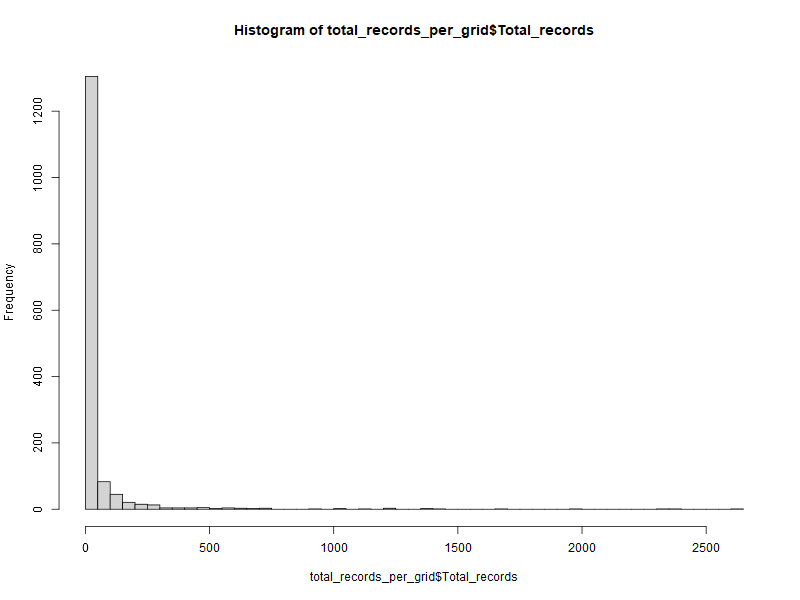

In [5]:
total_records_per_grid = recors_grid_10km %>%
  as.data.frame() %>%
  group_by(id)%>%
  summarise(Total_records = n()) %>%
  as.data.frame()
hist(total_records_per_grid$Total_records, breaks = 50)

Join results to 10 km grid

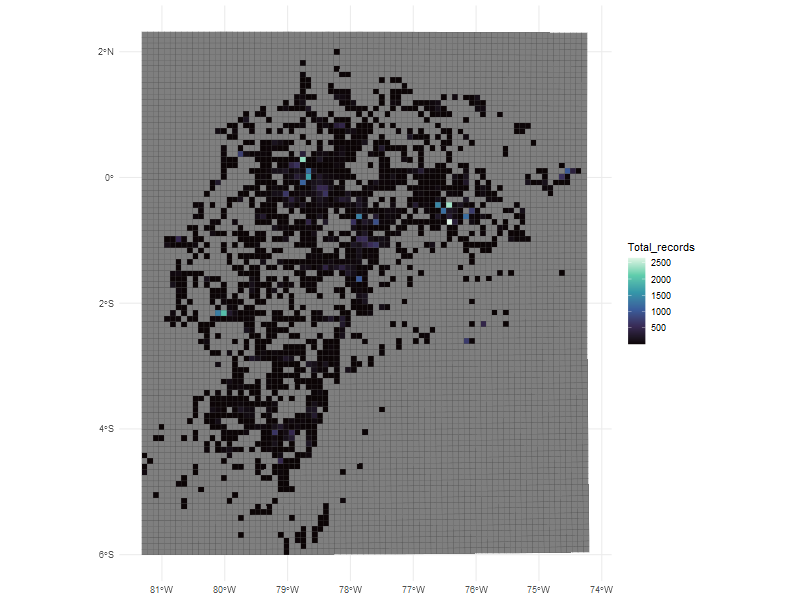

In [7]:
grid_10km = grid_10km%>% 
  left_join(total_records_per_grid, by = "id")

ggplot(grid_10km) +
  geom_sf(aes(fill = Total_records), color = "grey30", size = 0.1) +
  scale_fill_viridis_c(option = "mako") +
  theme_minimal()

# 5. Sp per 10 km grid

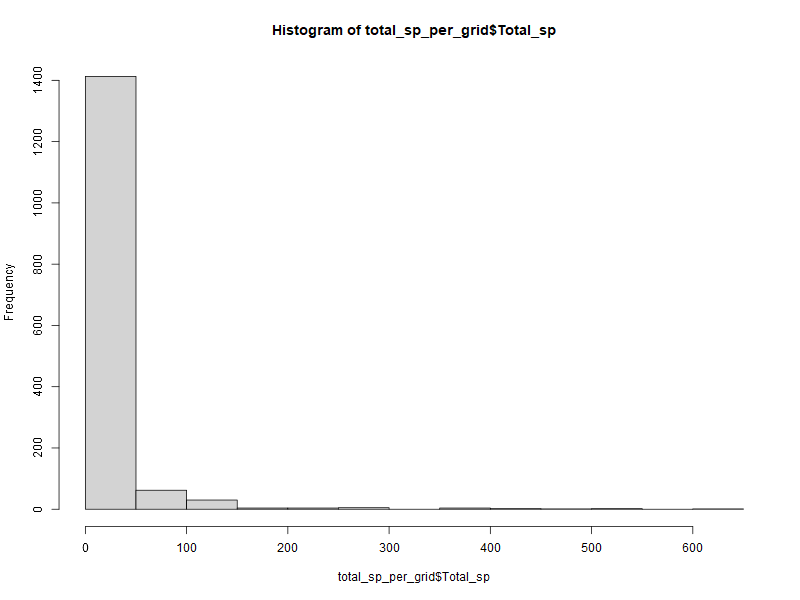

In [10]:
total_sp_per_grid = recors_grid_10km %>%
  as.data.frame() %>%
  group_by(id)%>%
  distinct(scientificName) %>%
  summarise(Total_sp = n()) %>%
  as.data.frame()
hist(total_sp_per_grid$Total_sp)

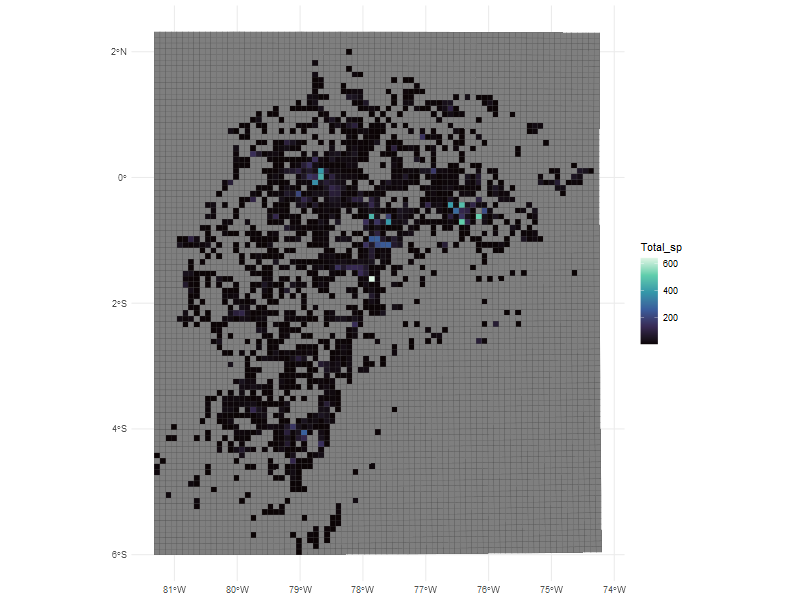

In [11]:
grid_10km = grid_10km%>% 
  left_join(total_sp_per_grid, by = "id")
ggplot(grid_10km) +
  geom_sf(aes(fill = Total_sp), color = "grey30", size = 0.1) +
  scale_fill_viridis_c(option = "mako") +
  theme_minimal()

## 5.1 Correlaction records x sp

In [12]:
cor(grid_10km$Total_records, grid_10km$Total_sp, method = "spearman", use = "complete.obs")

[1] 0.9554427

Warning messages:
1: Removed 5740 rows containing non-finite outside the scale range (`stat_smooth()`). 
2: Removed 5740 rows containing missing values or values outside the scale range (`geom_point()`). 


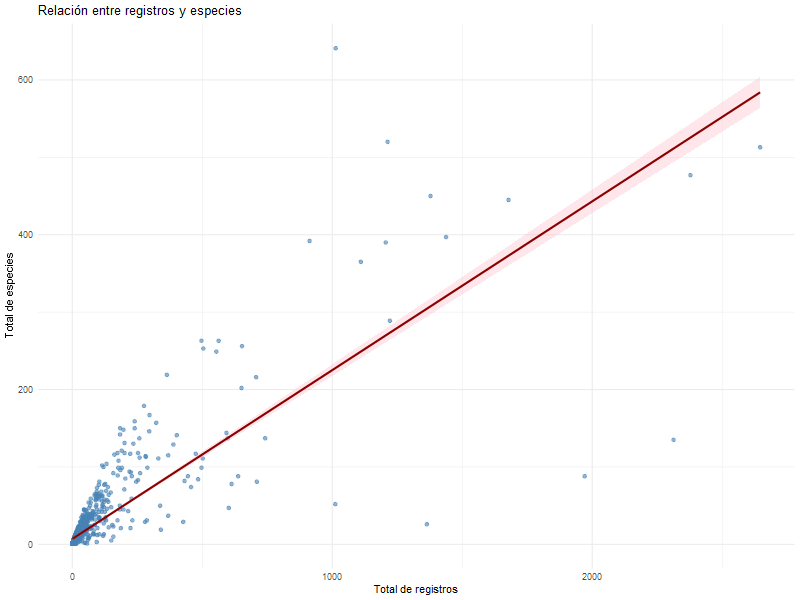

`geom_smooth()` using formula = 'y ~ x'

In [13]:
ggplot(grid_10km, aes(x = Total_records, y = Total_sp)) +
  geom_point(alpha = 0.6, color = "steelblue") +
  geom_smooth(method = "lm", se = TRUE, color = "darkred", fill = "pink") +
  theme_minimal() +
  labs(
    x = "Total de registros",
    y = "Total de especies",
    title = "Relación entre registros y especies"
  )

# 6. Sampling Completness

## 6.1. Completness - Country level

Calculate completnes for all country using incidens data and each 10 km cell is a unit

In [14]:
ecu_incidens_matrix <- recors_grid_10km %>%
  as.data.frame() %>%
  distinct(id, scientificName) %>%          # 1 por unidad-especie
  mutate(val = 1L) %>%
  pivot_wider(names_from = scientificName, values_from = val, values_fill = 0) %>%
  arrange(id)
ids_unidades_ecu <- ecu_incidens_matrix$id

# Quitamos la columna de IDs para dejar solo 0/1 por especie
incidences_ecu_df <- ecu_incidens_matrix %>% dplyr::select(-id)

# Matriz of incidences - iNext
inext_in_ecu <- list(ensamblaje = as.data.frame(t(incidences_ecu_df)))




Use iNEXT funtion to calculate the sampling coverage in Ecuador, an only extract richness (q=0) and sampling coverage

In [15]:
result_inext_ecu <- iNEXT(inext_in_ecu, q = 0, datatype = "incidence_raw", se = TRUE, conf = 0.95,nboot= 100 )
result_inext_ecu

Compare 1 assemblages with Hill number order q = 0.
$class: iNEXT

$DataInfo: basic data information
  Assemblage    T     U S.obs     SC   Q1   Q2  Q3  Q4  Q5  Q6  Q7  Q8 Q9 Q10
1 ensamblaje 1528 26231  8071 0.8366 4288 1372 699 387 279 190 135 110 88  84

$iNextEst: diversity estimates with rarefied and extrapolated samples.
$size_based (LCL and UCL are obtained for fixed size.)

   Assemblage    t        Method Order.q          qD      qD.LCL      qD.UCL        SC      SC.LCL    SC.UCL
1  ensamblaje    1   Rarefaction       0    17.16688    16.99631    17.33746 0.0103400 0.009873001 0.0108070
10 ensamblaje  764   Rarefaction       0  5459.56574  5401.44553  5517.68596 0.7512832 0.747112020 0.7554544
20 ensamblaje 1528      Observed       0  8071.00000  7974.30224  8167.69776 0.8365978 0.832286195 0.8409094
30 ensamblaje 2252 Extrapolation       0  9823.15360  9684.52530  9961.78190 0.8793530 0.874431354 0.8842746
40 ensamblaje 3056 Extrapolation       0 11237.17964 11043.95647 11430

In [16]:
info_inext_ecu <- DataInfo(inext_in_ecu, datatype = "incidence_raw")  # columna SC = sample coverage; T = # unidades de muestreo
info_inext_ecu


Warning messages:
1: In ggiNEXT.iNEXT(result_inext_ecu, type = 2) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q
2: `aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the iNEXT package.
  Please report the issue at <]8;;https://github.com/JohnsonHsieh/iNEXT/issueshttps://github.com/JohnsonHsieh/iNEXT/issues]8;;>.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated. 


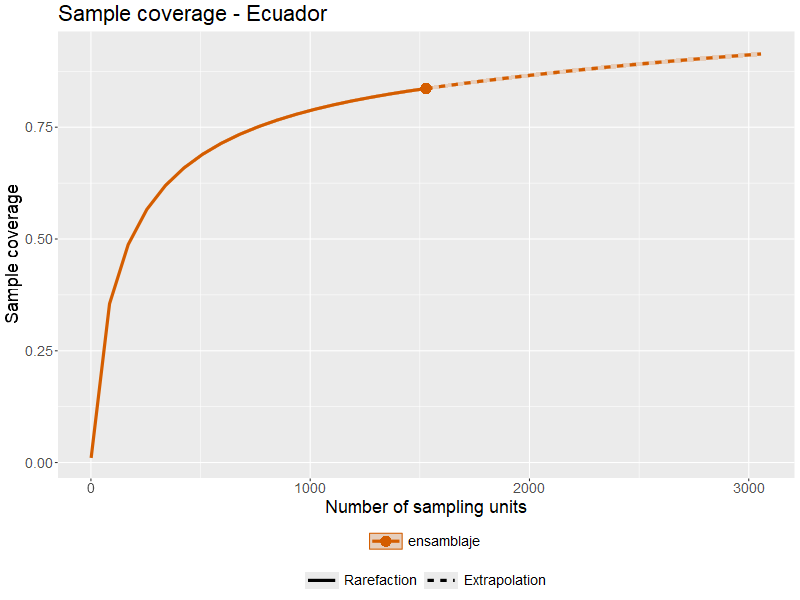

In [17]:
plot_units_sc <- ggiNEXT(result_inext_ecu, type = 2) + labs(title = "Sample coverage - Ecuador")
plot_units_sc

Warning message:
In ggiNEXT.iNEXT(result_inext_ecu, type = 1) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


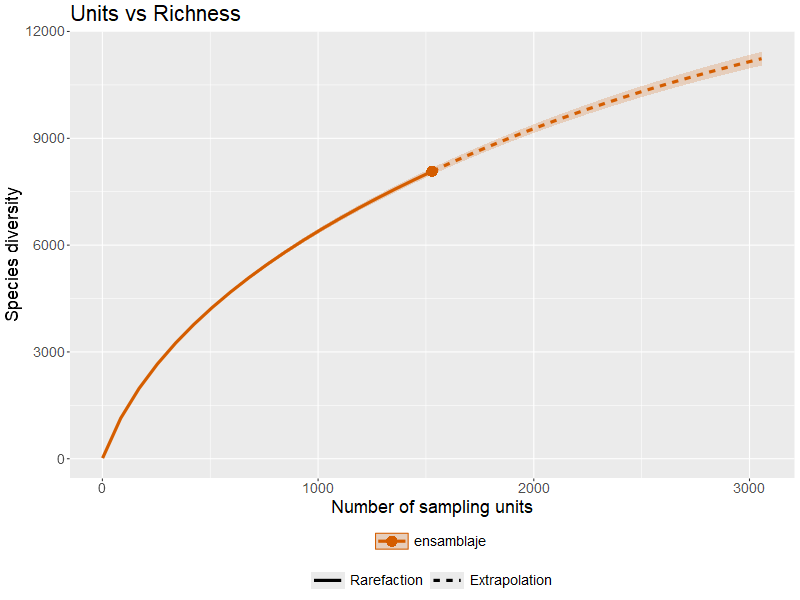

In [18]:
plot_units_richness <- ggiNEXT(result_inext_ecu, type = 1) + labs(title = "Units vs Richness")
plot_units_richness

## 6.2. Grid

### 6.2.1 Sample coverage

In [24]:
recors_grid_10km

Simple feature collection with 70917 features and 18 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -81.3037 ymin: -5.911483 xmax: -74.40273 ymax: 2.00376
Geodetic CRS:  WGS 84
First 10 features:
   id_record database_name database_id                         occurrenceID     basisOfRecord verbatimEventDate                                identifiedBy
1          2          BNDB  BNDB_10611 d7acf7c1-ac14-410f-a636-bb6568b11e49 PreservedSpecimen        1987-08-06                                 Dressler R.
2          4          BNDB  BNDB_10613 69a0389d-65cc-4d77-8c0e-d0ccc84ea7fb PreservedSpecimen        2015-07-04                                Bonifacii R.
3          6          BNDB  BNDB_10615 077e2a7f-7bd5-45fa-b755-c73a64708355 PreservedSpecimen        2015-07-04                                Bonifacii R.
4          8          BNDB  BNDB_10617 431219fe-57b1-489b-aeba-cf5ea796076d PreservedSpecimen        2015-07-04                                Bonifacii R.
5   

In [25]:
# Unique 10-km IDs
cid_10km <- unique(recors_grid_10km$id)

# Results container (abundance-based)
results_s_cov <- data.frame(
  id_10km = integer(),
  Samplig_coverage = numeric(),  # SC observado (abundancia)
  n_records = numeric(),         # n total de registros
  sp_obs = numeric(),         # S.obs
  f1 = numeric(),                # singletons
  f2 = numeric(),                # doubletons
  sc_ext = numeric(),            # SC al extremo de la curva
  n_records_ext = numeric(),     # n (size) al extremo
  sp_ext = numeric(),         # qD al extremo
  stringsAsFactors = FALSE
)

# Progress bar
pb <- txtProgressBar(min = 0, max = length(cid_10km), style = 3)
count <- 0

for (i in cid_10km) {

  # 1) Filtrar todo dentro del 10-km (SIN usar id_2km)
  records_by_id <- recors_grid_10km %>%
    dplyr::filter(id == i)

  # 2) Vector de abundancias por género (n° de registros por género)
  #    - quitar NAs en genus
  #    - quedarnos con géneros con n > 0
  abund_tbl <- records_by_id %>%
    dplyr::filter(!is.na(scientificName)) %>%
    dplyr::count(scientificName, name = "n")

  abund_vec <- abund_tbl$n
  names(abund_vec) <- abund_tbl$scientificName
  abund_vec <- abund_vec[abund_vec > 0]

  # 3) Casos sin información suficiente
  if (length(abund_vec) == 0L) {
    sampl_result <- data.frame(
      Samplig_coverage = NA_real_,
      n_records = NA_real_,
      sp_obs = NA_real_,
      f1 = NA_real_,
      f2 = NA_real_,
      sc_ext = NA_real_,
      n_records_ext = NA_real_,
      sp_ext = NA_real_,
      stringsAsFactors = FALSE
    )
  } else {
    # 4) iNEXT con abundancias (curva en función de # de registros)
    sampl_result <- tryCatch({
      res_abund <- iNEXT(
        list(ensamblaje = abund_vec),
        q = 0,
        datatype = "abundance",
        se = FALSE
      )

      # DataInfo (abundance)
      sc_obs <- res_abund$DataInfo$SC
      n_obs  <- res_abund$DataInfo$n
      s_obs  <- res_abund$DataInfo$S.obs
      f1     <- res_abund$DataInfo$f1
      f2     <- res_abund$DataInfo$f2

      # coverage_based: SC y qD al extremo (última fila)
      cb <- res_abund$iNextEst$coverage_based
      sc_ext <- if (!is.null(cb) && nrow(cb) > 0) tail(cb$SC, 1) else NA_real_
      qd_ext <- if (!is.null(cb) && nrow(cb) > 0) tail(cb$qD, 1) else NA_real_

      # size_based: n (m) al extremo (última fila)
      sb <- res_abund$iNextEst$size_based
      n_ext <- if (!is.null(sb) && nrow(sb) > 0) tail(sb$m, 1) else NA_real_

      data.frame(
        Samplig_coverage = sc_obs,
        n_records = n_obs,
        sp_obs = s_obs,
        f1 = f1,
        f2 = f2,
        sc_ext = sc_ext,
        n_records_ext = n_ext,
        sp_ext = round(qd_ext, 0),
        stringsAsFactors = FALSE
      )
    }, error = function(e) {
      data.frame(
        Samplig_coverage = NA_real_,
        n_records = NA_real_,
        sp_obs = NA_real_,
        f1 = NA_real_,
        f2 = NA_real_,
        sc_ext = NA_real_,
        n_records_ext = NA_real_,
        sp_ext = NA_real_,
        stringsAsFactors = FALSE
      )
    })
  }

  # 5) Append por celda 10-km
  results_s_cov <- rbind(
    results_s_cov,
    cbind(data.frame(id_10km = i, stringsAsFactors = FALSE), sampl_result)
  )

  count <- count + 1
  setTxtProgressBar(pb, count)
}

# Close progress bar
close(pb)



  |=============================================================================================================================================================| 100%

There were 50 or more warnings (use warnings() to see the first 50)


In [26]:
results_s_cov

    id_10km Samplig_coverage n_records sp_obs  f1  f2    sc_ext n_records_ext sp_ext
1      1606           0.4857         7      5   4   0 0.7540187            14      8
2      2228           0.6755        70     39  23  10 0.8649594           140     54
3      2508           0.8720       593    144  76  23 0.9301537          1186    201
4      2868           0.4243        64     47  37   5 0.5622989           128     79
5      4814           0.6708       115     56  38   8 0.7845435           230     87
6      4907           0.6497        25     15   9   3 0.8234277            50     21
7      3185           0.4857         5      4   3   1 0.7620583            10      6
8      2145           0.5875       104     58  43   5 0.6737194           208     96
9      4999           0.9117      2378    477 210  85 0.9607174          4756    621
10     4815           0.8714      1438    397 185  78 0.9446911          2876    522
11     3364           1.0000        31      4   1   0 1.0000000  

### 6.2.4  Join Sample covergate with 10 km grid

In [46]:
results_sampling_effor

   id_10km Samplig_coverage n_records sp_obs  f1  f2    sc_ext n_records_ext sp_ext   id      left      top     right   bottom Total_records Total_sp
1     2228           0.6755        70     39  23  10 0.8649594           140     54 2228  704459.9 10066386  714459.9 10056386            70       39
2     2508           0.8720       593    144  76  23 0.9301537          1186    201 2508  734459.9 10026386  744459.9 10016386           593      144
3     2868           0.4243        64     47  37   5 0.5622989           128     79 2868  774459.9 10106386  784459.9 10096386            64       47
4     4814           0.6708       115     56  38   8 0.7845435           230     87 4814  984459.9  9966386  994459.9  9956386           115       56
5     2145           0.5875       104     58  43   5 0.6737194           208     96 2145  694459.9  9976386  704459.9  9966386           104       58
6     4999           0.9117      2378    477 210  85 0.9607174          4756    621 4999 1004459.9  

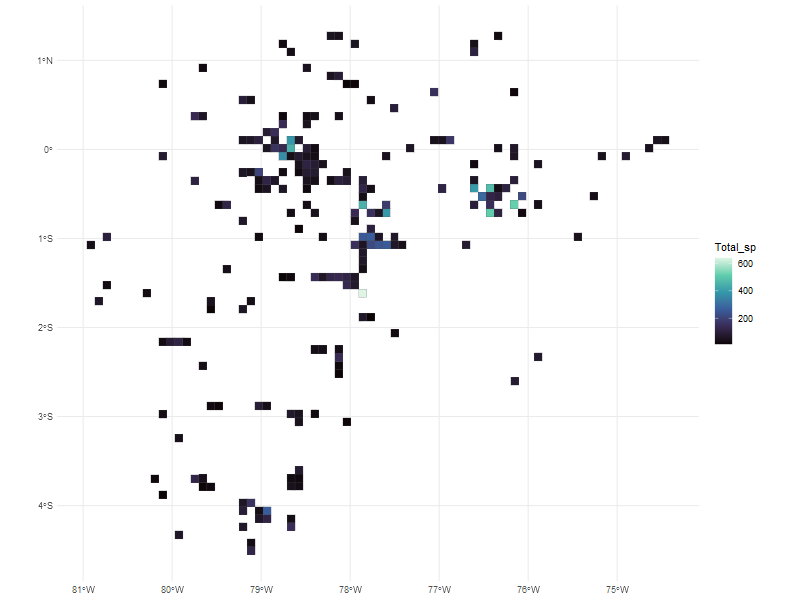

In [47]:
results_sampling_effor =  grid_10km%>%
  left_join(results_s_cov, by = "id_10km") %>% filter(Total_records >= 50 )%>%
    filter(Total_sp >= 10)

ggplot(results_sampling_effor) +
  geom_sf(aes(fill = Total_sp ), color = "grey30", size = 0.1) +
  scale_fill_viridis_c(option = "mako") +
  theme_minimal()

# 7. Exportar resultados

In [48]:

 st_write(results_sampling_effor, "Results/shp/grid_10km_samping_filter.shp", append=FALSE)

Deleting layer `grid_10km_samping_filter' using driver `ESRI Shapefile'
Writing layer `grid_10km_samping_filter' to data source `Results/shp/grid_10km_samping_filter.shp' using driver `ESRI Shapefile'
Writing 217 features with 16 fields and geometry type Polygon.


Warning message:
In abbreviate_shapefile_names(obj) :
  Field names abbreviated for ESRI Shapefile driver
